# Morse decoder

Experimental morse code decoder from wav file.

Logic:
1. detect lead frequency;
2. filter frequency;
3. get magnitudes;
4. square magnitudes to 1/0 groups;
5. get K-mean clusters of signals and pauses;
6. decode dash/dots into letters and words.

In [1]:
MORSE_LETTERS = {
    "A": ".-", "B": "-...", "C": "-.-.", "D": "-..", "E": ".", "F": "..-.", "G": "--.", "H": "....", "I": "..",
    "J": ".---", "K": "-.-", "L": ".-..", "M": "--", "N": "-.", "O": "---", "P": ".--.", "Q": "--.-", "R": ".-.",
    "S": "...", "T": "-", "U": "..-", "V": "...-", "W": ".--", "X": "-..-", "Y": "-.--", "Z": "--..",
}

MORSE_DIGITS = {
    "0": "-----", "1": ".----", "2": "..---", "3": "...--", "4": "....-",
    "5": ".....", "6": "-....", "7": "--...", "8": "---..", "9": "----.",
}

MORSE_PUNCTS = {
    ".": ".-.-.-", ",": "--..--", "?": "..--..",
}

MORSE_TABLE = {
    **MORSE_LETTERS,
    **MORSE_DIGITS,
    **MORSE_PUNCTS,
    " ": " ",
}

MORSE_DECODE = {
    v: k for k, v in MORSE_TABLE.items()
}

## Lib import

In [2]:
import numpy as np

from scipy import signal, stats
from scipy.io.wavfile import read

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from itertools import groupby

## Inputs

In [3]:
inputfile = "cw/cw8.wav"

# Set up variables
threshold_value = 0.05 #Normalised to varience of signal
detection_threshold = 0.03 #Value to determine if a signal is present
t_start = None #0
#t_end = t_start + 1

## Signal processing

In [4]:
# Simple DC removal algorithem
def remove_dc(wav_data):
    return wav_data - np.mean(wav_data)

# Generate PSD of file to work out the CF of the CW signal
def find_carrier(wav_data, sample_rate):
    f, Pxx_den = signal.welch(wav_data, sample_rate, nperseg=2048)
    
    max_value = np.argmax(Pxx_den)
    carrier_freq = f[max_value]
    
    # Plot
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
    
    return carrier_freq

# From the CF of the CW signal - generate I and Q carriers to downsample the signal to baseband
def generate_carriers(wav_data, sample_rate, carrier_freq):
    rate = sample_rate  # samples per second
    sample_length = len(wav_data)         # sample duration (seconds)
    f = carrier_freq     # sound frequency (Hz)
    t = np.linspace(0, sample_length/rate, sample_length, endpoint=False)
    sin_car = np.sin(2*np.pi * f * t)
    cos_car = np.cos(2*np.pi * f * t)
    print("Carriers Generated")
    return sin_car, cos_car

# Design LPF to remove signal away from baseband
# TODO pull out filter design parms
def design_lpf(fs):
    nyq_rate = fs/2

    # Help from -->> https://scipy-cookbook.readthedocs.io/items/FIRFilter.html

    # The desired width of the transition from pass to stop,
    # relative to the Nyquist rate.  We'll design the filter
    # with a 5 Hz transition width.
    width = 500/nyq_rate

    # The desired attenuation in the stop band, in dB.
    ripple_db = 40.0

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = signal.kaiserord(ripple_db, width)

    # The cutoff frequency of the filter.
    cutoff_hz = 100.0

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    
    print("Filter of order %i deisgned" % len(taps))

    # Plot
    w, h = signal.freqz(taps, worN=8000)
    plt.plot((w/np.pi)*nyq_rate, 20 * np.log(np.absolute(h)), linewidth=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.title('Frequency Response')
    #ylim(-0.05, 1.05)
    plt.grid(True)
    plt.show()
        
    return taps

# Downsample signal and apply LPF
def generate_filtered_baseband(wav_data, sample_rate, carriers):
    taps = design_lpf(sample_rate)
    
    i_wave = carriers[0] * wav_data
    q_wave = carriers[1] * wav_data
    
    # Use lfilter to filter x with the FIR filter.
    filtered_i = signal.lfilter(taps, 1.0, i_wave)
    filtered_q = signal.lfilter(taps, 1.0, q_wave)
    
    return filtered_i, filtered_q

# Downsample audio file to 1000 Hz
# TODO pipe thorugh fs so different fs can be supported
def downsample_abs_bb(baseband_data, fs):
    i_chan = baseband_data[0]
    q_chan = baseband_data[1]
    
    N = int(fs/1000) # 48000/48 = 1000
    bb_len = len(i_chan)
    
    truncate_len = np.mod(bb_len, N)
    i_chan = i_chan[:bb_len-truncate_len]
    q_chan = q_chan[:bb_len-truncate_len]
    
    i_chan_ds = i_chan.reshape((int(len(i_chan)/N), N))
    q_chan_ds = q_chan.reshape((int(len(q_chan)/N), N))
    
    i_chan_ds = np.sum(i_chan_ds, axis = 1)
    q_chan_ds = np.sum(q_chan_ds, axis = 1)
    
    return i_chan_ds, q_chan_ds
    
# Compute magnitude of signal and normalise
def compute_abs(downsampled_power_data):
    sqr_dat = np.square(downsampled_power_data[0]) + np.square(downsampled_power_data[1])
    sqr_dat = np.sqrt(sqr_dat)
    ## https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
    #sqr_dat = sqr_dat / np.max(np.abs(sqr_dat))
    return sqr_dat/max(sqr_dat)

# Use a window to smooth the vector
# TODO Very inefficient...
def smooth_mag(mag, window_len = 10, No_iter = 20):
    for i in range(0, No_iter):
        mag = np.convolve(mag, np.ones((window_len,))/window_len, mode='valid')
    return mag

# Determine the value of the power threshold
def get_threshold_val(mag, location, thresh = 0.5, search_len = 1000):
    #Define search area
    min_search = location-search_len/2
    if min_search < 0:
        min_search = 0
        
    max_search = location+search_len/2
    if max_search > len(mag) - 1:
        max_search = len(mag) - 1
    
    # "Cut out" vector to be searched and return max and min
    #search_vector = mag[int(min_search):int(max_search)]
    min_val = np.min(mag[int(min_search):int(max_search)])
    max_val = np.max(mag[int(min_search):int(max_search)])
    
    delta = max_val - min_val
    
    # Convert rel value to abs value
    threshold_val = min_val + delta*thresh
    
    return threshold_val

# Iterate through vector and compute threshold
# TODO can be made a lot more efficient by only sampling every N samples (as the value will move rather slowly... I think... )
def get_threshold(mag, thresh = 0.5):
    thresh_vector = np.zeros(mag.shape)
    for i in range(0, len(mag)):
        thresh_vector[i] = get_threshold_val(mag, i)
    
    return thresh_vector

# Determine the coefficient for signal detection
def signal_detect_val(mag, location, thresh = 0.5, search_len = 1000):
    min_search = location-search_len/2
    if min_search < 0:
        min_search = 0
        
    max_search = location+search_len/2
    if max_search > len(mag) - 1:
        max_search = len(mag) - 1

    search_vector = mag[int(min_search):int(max_search)]
    
    return np.std(search_vector)
    
# Iterate through vector and compute threshold
# TODO work out method of computing the detection_threshold (fixed atm). Probably something to do with the fs and noise of sound card (so can probably be assumed)
def signal_detect(mag, detection_threshold = 0.1):
    signal_detect_vector = np.zeros(mag.shape)
    for i in range(0, len(mag)):
        signal_detect_vector[i] = signal_detect_val(mag, i)
    
    signal_detect_vector = (signal_detect_vector > detection_threshold)
    
    return signal_detect_vector

# Apply the power threshold
def apply_threshold(mag, thresh_vector):
    return mag - thresh_vector

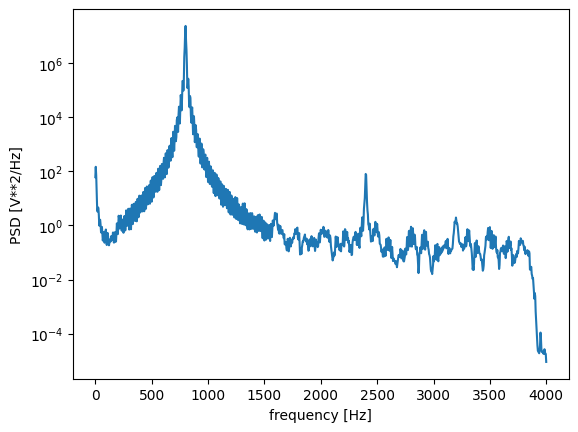

Carrier found at 800.7812fHz
Carriers Generated
Filter of order 37 deisgned


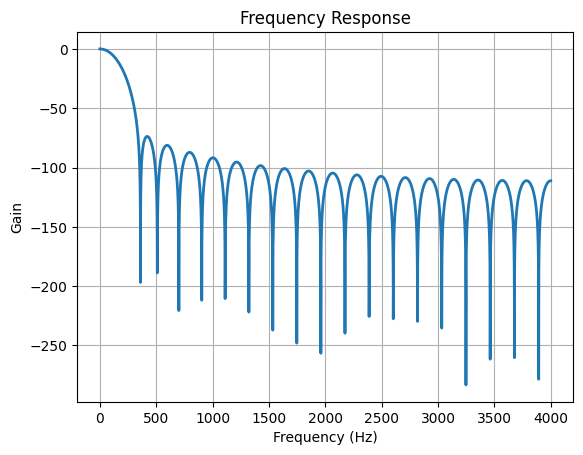

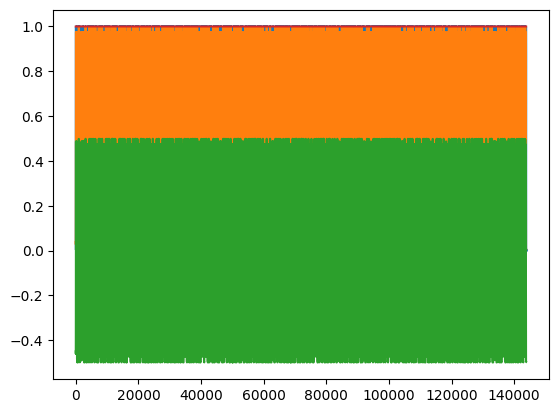

In [5]:
sample_rate, wav_file = read(inputfile)

if t_start is not None:
    wav_file = wav_file[t_start * sample_rate:t_end * sample_rate]

wav_file = remove_dc(wav_file) # Remove any DC present in the array.
# TODO - Compute this for the file in sections as the satellite tracking algorithem will not be perfect! 
carrier_freq = find_carrier(wav_file, sample_rate) # Locate cw carrier (single for now)
print(f"Carrier found at {carrier_freq:0.4f}fHz")
# TODO implement the changing freq (change from above!)
carriers = generate_carriers(wav_file, sample_rate, carrier_freq) # Generate baseband shifting carriers
baseband_data = generate_filtered_baseband(wav_file, sample_rate, carriers) # Designs a FIR filter to remove non-CW components
downsampled_power_data = downsample_abs_bb(baseband_data, sample_rate) # Dowsample full rate file to 1000Hz
magnitude_data = compute_abs(downsampled_power_data) # Calculate the magnitude vector of the IQ
magnitude_data_smoothed = smooth_mag(magnitude_data) # Smooth the magnitude vector (convolutional method)
thresh_vector = get_threshold(magnitude_data_smoothed, thresh = threshold_value) # Generate threshold vector to determine the level at which a signal is present
shifted_mag = apply_threshold(magnitude_data_smoothed, thresh_vector) # Use the threshold vector to return a zero mean signal
# Detect if a CW signal is present (or any signal for that matter) by looking at the standard deviation
signal_present = signal_detect(magnitude_data_smoothed, detection_threshold = detection_threshold)

for i in [magnitude_data, magnitude_data_smoothed, shifted_mag, signal_present]:
    plt.plot(i)
plt.show()

## Square magnitudes to 1/0 function

Text(0.5, 1.0, 'Square wave')

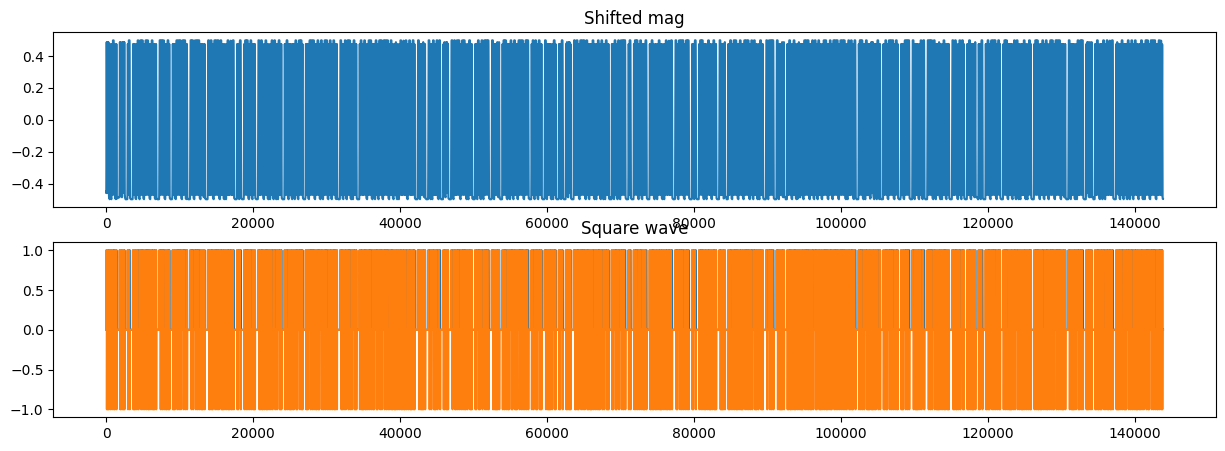

In [6]:
threshold = 0.1
square_wave = np.where(shifted_mag > threshold, 1, 0)
square_wave[-1] = 0
square_diff = np.diff(square_wave)

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].plot(shifted_mag)
axes[0].set_title("Shifted mag")

axes[1].plot(square_wave)
axes[1].plot(square_diff)
axes[1].set_title("Square wave")

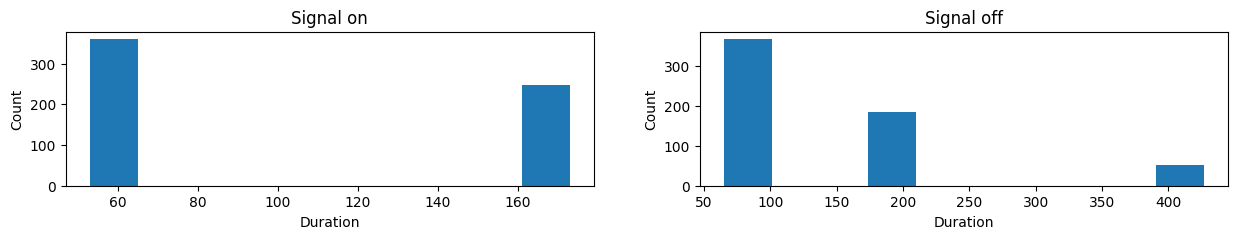

In [7]:
rising_idx = np.nonzero(square_diff == 1)[0]
falling_idx = np.nonzero(square_diff == -1)[0]

# Case: data starts with ON - it started one sample before index 0
if falling_idx[0] < rising_idx[0]:
    rising_idx = np.insert(rising_idx, 0, -1)

# Case: data ends with ON
if rising_idx[-1] > falling_idx[-1]:
    falling_idx = np.insert(falling_idx, len(falling_idx), len(falling_idx) - 1)

on_samples = falling_idx - rising_idx
off_samples = rising_idx[1:] - falling_idx[: len(falling_idx) - 1]

fig, axes = plt.subplots(1, 2, figsize=(15, 2))
axes[0].hist(on_samples)
axes[0].set_title("Signal on")

axes[1].hist(off_samples)
axes[1].set_title("Signal off")

for ax in axes:
    ax.set_ylabel("Count")
    ax.set_xlabel("Duration")

## Decoding

In [8]:
one_lengths = on_samples.reshape(-1, 1)
zero_lengths = off_samples.reshape(-1, 1)
# print(one_lengths)
# print(zero_lengths)

def morse_clustering_decode(ones, zeros):
    # Ones
    kmeans_ones = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(one_lengths)
    one_cluster_sort_idx = np.argsort(kmeans_ones.cluster_centers_.flatten()).tolist()
    dot_label = one_cluster_sort_idx.index(0)
    dash_label = one_cluster_sort_idx.index(1)
    one_map = {dot_label: '.', dash_label: '-'}
    # Zeros
    kmeans_zeros = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(zero_lengths)
    zero_cluster_sort_idx = np.argsort(kmeans_zeros.cluster_centers_.flatten()).tolist()
    nonbreak_label = zero_cluster_sort_idx.index(0)
    space_label = zero_cluster_sort_idx.index(1)
    break_label = zero_cluster_sort_idx.index(2)
    # Chunking
    chunks = [(gr, sum(1 for it in items)) for gr, items in groupby(square_wave)]
    # print(chunks)
    morse_words = []
    morse_str = ''
    for bit, count in chunks:
        if bit == 1:  # Определяем точка или тире
            one_label = kmeans_ones.predict([[count]])[0]
            symbol = one_map[one_label]
            # print(count, one_label, symbol)
            morse_str += symbol
        else:
            zero_label = kmeans_zeros.predict([[count]])[0]
            if zero_label == space_label:
                morse_str += ' '
            elif zero_label == break_label:
                morse_words.append(morse_str)
                morse_str = ''
    
    if morse_str:
        morse_words.append(morse_str)

    return morse_words

morse_words = morse_clustering_decode(one_lengths, zero_lengths)
for morse_word in morse_words:
    word_list = list(map(lambda m: MORSE_DECODE.get(m, f"<{m}>"), morse_word.split()))
    print("Text:", "".join(word_list), "\t\tMorse:", morse_word)

Text: SERE 		Morse: ... . .-. .
Text: IS 		Morse: .. ...
Text: A 		Morse: .-
Text: SAMPLE 		Morse: ... .- -- .--. .-.. .
Text: OF 		Morse: --- ..-.
Text: SOME 		Morse: ... --- -- .
Text: MOSE 		Morse: -- --- ... .
Text: CODE. 		Morse: -.-. --- -.. . .-.-.-
Text: IT 		Morse: .. -
Text: WAS 		Morse: .-- .- ...
Text: CREATED 		Morse: -.-. .-. . .- - . -..
Text: USING 		Morse: ..- ... .. -. --.
Text: SOFTWARE 		Morse: ... --- ..-. - .-- .- .-. .
Text: NAMED 		Morse: -. .- -- . -..
Text: <.-..-.>WINMORSE.<.-..-.> 		Morse: .-..-. .-- .. -. -- --- .-. ... . .-.-.- .-..-.
Text: THE 		Morse: - .... .
Text: TEXT 		Morse: - . -..- -
Text: IS 		Morse: .. ...
Text: TYPED 		Morse: - -.-- .--. . -..
Text: INTO 		Morse: .. -. - ---
Text: THE 		Morse: - .... .
Text: WINDOW 		Morse: .-- .. -. -.. --- .--
Text: AND 		Morse: .- -. -..
Text: THEN 		Morse: - .... . -.
Text: IT 		Morse: .. -
Text: IS 		Morse: .. ...
Text: CONVERTED 		Morse: -.-. --- -. ...- . .-. - . -..
Text: INTO 		Morse: .. -. - ---
Text:

## References
* [morse-audio-decoder](https://github.com/mkouhia/morse-audio-decoder/blob/main/notebooks/2022-02-23%20Wundernut%2011%20exploration.ipynb)
* [PyRSCW](https://github.com/m0zjo-code/PyRSCW/blob/master/pyrscwlib.py)
* [Extended morse table](https://morsecode.world/international/morse.html)